# Librairies

## Install Package

In [1]:
import os
import json
import numpy as np
import pandas as pd
import keras
import gc
import os
import json
import logging
import datetime
import warnings
import seaborn as sns
import cv2
import random
import keras
from PIL import Image
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 
warnings.filterwarnings('ignore')

from glob import glob

Using TensorFlow backend.


# Data pre-processing

## Call API Kaggle and configuration Dataset


## Load Data


In [2]:
!ls

brouillon_commun.ipynb	iwildcam_2019_fgvc6
cifar10_example		kaggle_competition_iWildCam.ipynb


In [3]:
train_df = pd.read_csv('iwildcam_2019_fgvc6/train.csv')
test_df = pd.read_csv('iwildcam_2019_fgvc6/test.csv')

In [4]:
train_df.head()

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747
2,0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747
3,0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747
4,0,2011-07-12 13:11:16,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,3,599fbd89-23d2-11e8-a6a3-ec086b02610b,46,Justin Brown,6f1728a1-5567-11e8-9be7-dca9047ef277,3,1024,747


In [5]:
test_df.head()

,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
0,2016-01-03 11:30:56,bce932f6-2bf6-11e9-bcad-06f10d5896c4.jpg,1,bce932f6-2bf6-11e9-bcad-06f10d5896c4,37,Idaho Department of Fish and Game,6e9ac61c-2e32-11e9-90ef-dca9047ef277,5,1024,726
1,2016-01-03 11:30:57,bce932f7-2bf6-11e9-bcad-06f10d5896c4.jpg,2,bce932f7-2bf6-11e9-bcad-06f10d5896c4,37,Idaho Department of Fish and Game,6e9ac61c-2e32-11e9-90ef-dca9047ef277,5,1024,726
2,2016-01-03 11:30:58,bce932f8-2bf6-11e9-bcad-06f10d5896c4.jpg,3,bce932f8-2bf6-11e9-bcad-06f10d5896c4,37,Idaho Department of Fish and Game,6e9ac61c-2e32-11e9-90ef-dca9047ef277,5,1024,726
3,2016-01-03 11:30:59,bce932f9-2bf6-11e9-bcad-06f10d5896c4.jpg,4,bce932f9-2bf6-11e9-bcad-06f10d5896c4,37,Idaho Department of Fish and Game,6e9ac61c-2e32-11e9-90ef-dca9047ef277,5,1024,726
4,2016-01-03 11:31:00,bce932fa-2bf6-11e9-bcad-06f10d5896c4.jpg,5,bce932fa-2bf6-11e9-bcad-06f10d5896c4,37,Idaho Department of Fish and Game,6e9ac61c-2e32-11e9-90ef-dca9047ef277,5,1024,726


In [6]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (196299, 11) (153730, 10)


## Data exploration

In [7]:
# Let's define the classes:
classes_wild = {0: 'empty', 1: 'deer', 2: 'moose', 3: 'squirrel', 4: 'rodent', 5: 'small_mammal', \
                6: 'elk', 7: 'pronghorn_antelope', 8: 'rabbit', 9: 'bighorn_sheep', 10: 'fox', 11: 'coyote', \
                12: 'black_bear', 13: 'raccoon', 14: 'skunk', 15: 'wolf', 16: 'bobcat', 17: 'cat',\
                18: 'dog', 19: 'opossum', 20: 'bison', 21: 'mountain_goat', 22: 'mountain_lion'}

In [8]:
train_df['classes_wild'] = train_df['category_id'].apply(lambda cw: classes_wild[cw])

### Check images

In [9]:
train_image_files = list('train_images')
test_image_files = list('test_images')
                         
print("Number of image files: train:{} test:{}".format(len(train_image_files), len(test_image_files)))

Number of image files: train:12 test:11


In [10]:
%%time
train_file_names = list(train_df['file_name'])
print("Matching train image names: {}".format(len(set(train_file_names).intersection(train_image_files))))

Matching train image names: 0
CPU times: user 50 ms, sys: 10 ms, total: 60 ms
Wall time: 63.4 ms


In [11]:
%%time
test_file_names = list(test_df['file_name'])
print("Matching test image names: {}".format(len(set(test_file_names).intersection(test_image_files))))

Matching test image names: 0
CPU times: user 50 ms, sys: 0 ns, total: 50 ms
Wall time: 51.1 ms


### Clases of images

In [12]:
cnt_classes_images = train_df.classes_wild.nunique()
print("There are {} classes of images".format(cnt_classes_images))
pd.DataFrame(train_df.classes_wild.value_counts()).transpose()

There are 14 classes of images


,empty,opossum,raccoon,coyote,rabbit,deer,bobcat,cat,squirrel,dog,rodent,skunk,fox,mountain_lion
classes_wild,131457,14106,8623,7209,6938,6102,5975,4759,3398,3035,2210,1361,1093,33


### Number of sequences frames

In [13]:
def plot_classes(feature, fs=8, show_percents=True, color_palette='Set3'):
    f, ax = plt.subplots(1,1, figsize=(2*fs,4))
    total = float(len(train_df))
    g = sns.countplot(train_df[feature], order = train_df[feature].value_counts().index, palette=color_palette)
    g.set_title("Number and percentage of labels for each class of {}".format(feature))
    if(show_percents):
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(100*height/total),
                    ha="center") 
    plt.show()    

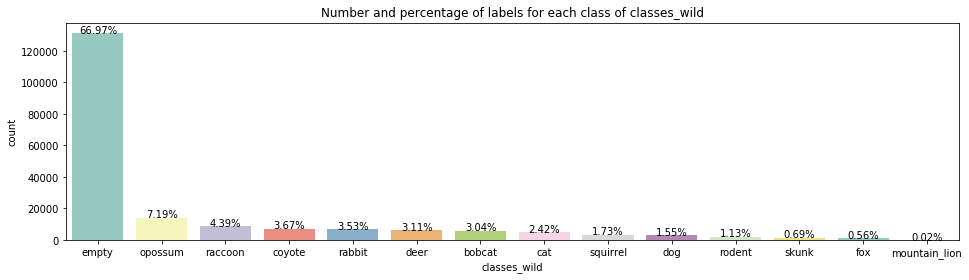

In [14]:
plot_classes('classes_wild')

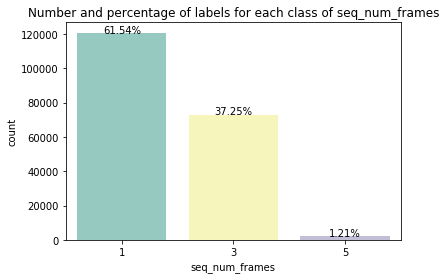

In [15]:
plot_classes('seq_num_frames', fs=3)

### Locations distribution

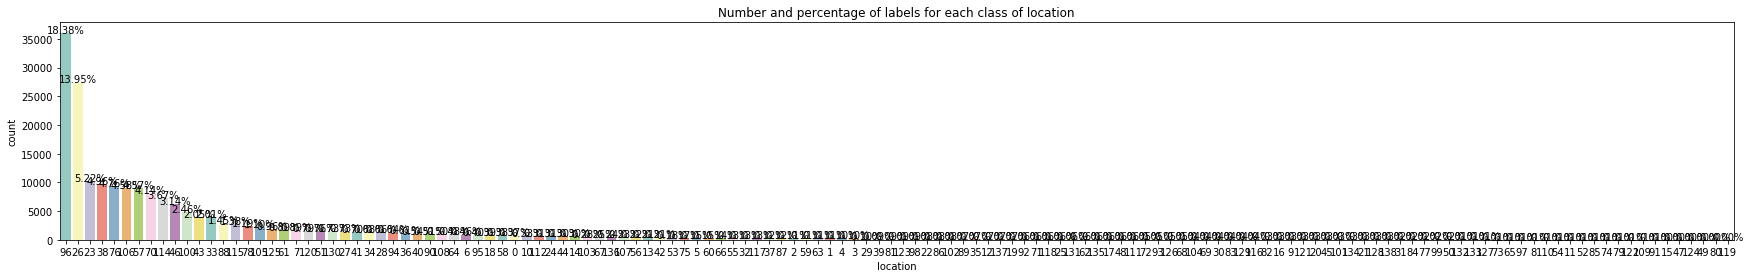

In [16]:
plot_classes('location', fs=15)

### Locations and classes

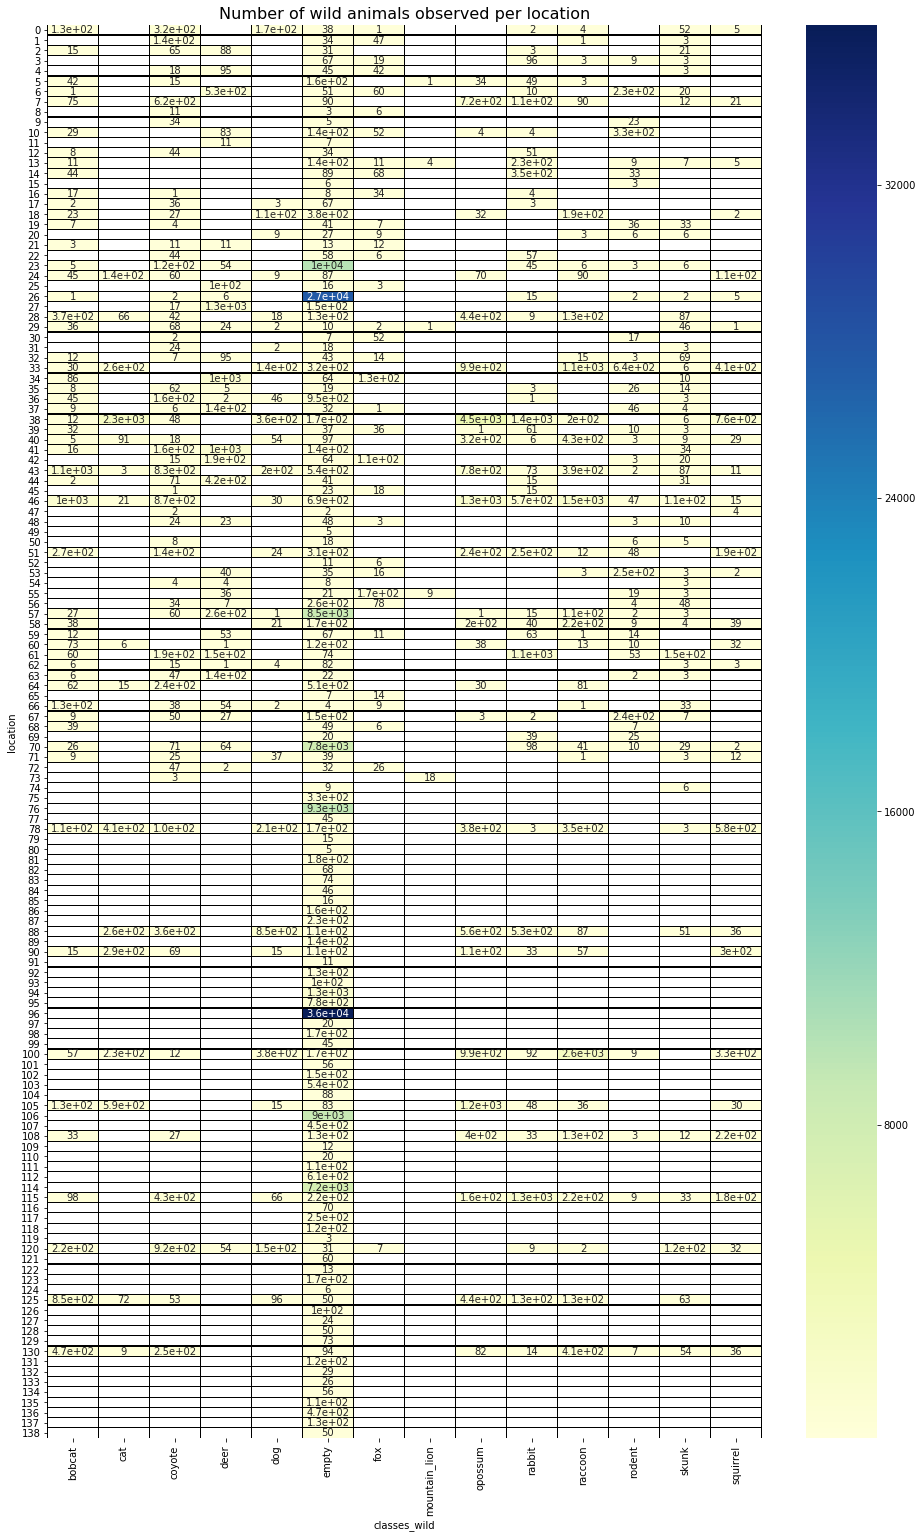

In [17]:
fig, ax = plt.subplots(1,1,figsize=(16,26))
t = pd.DataFrame(train_df.groupby(['classes_wild', 'location'])['seq_id'].count().reset_index())
m = t.pivot(index='location', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed per location', size=16)
plt.show()

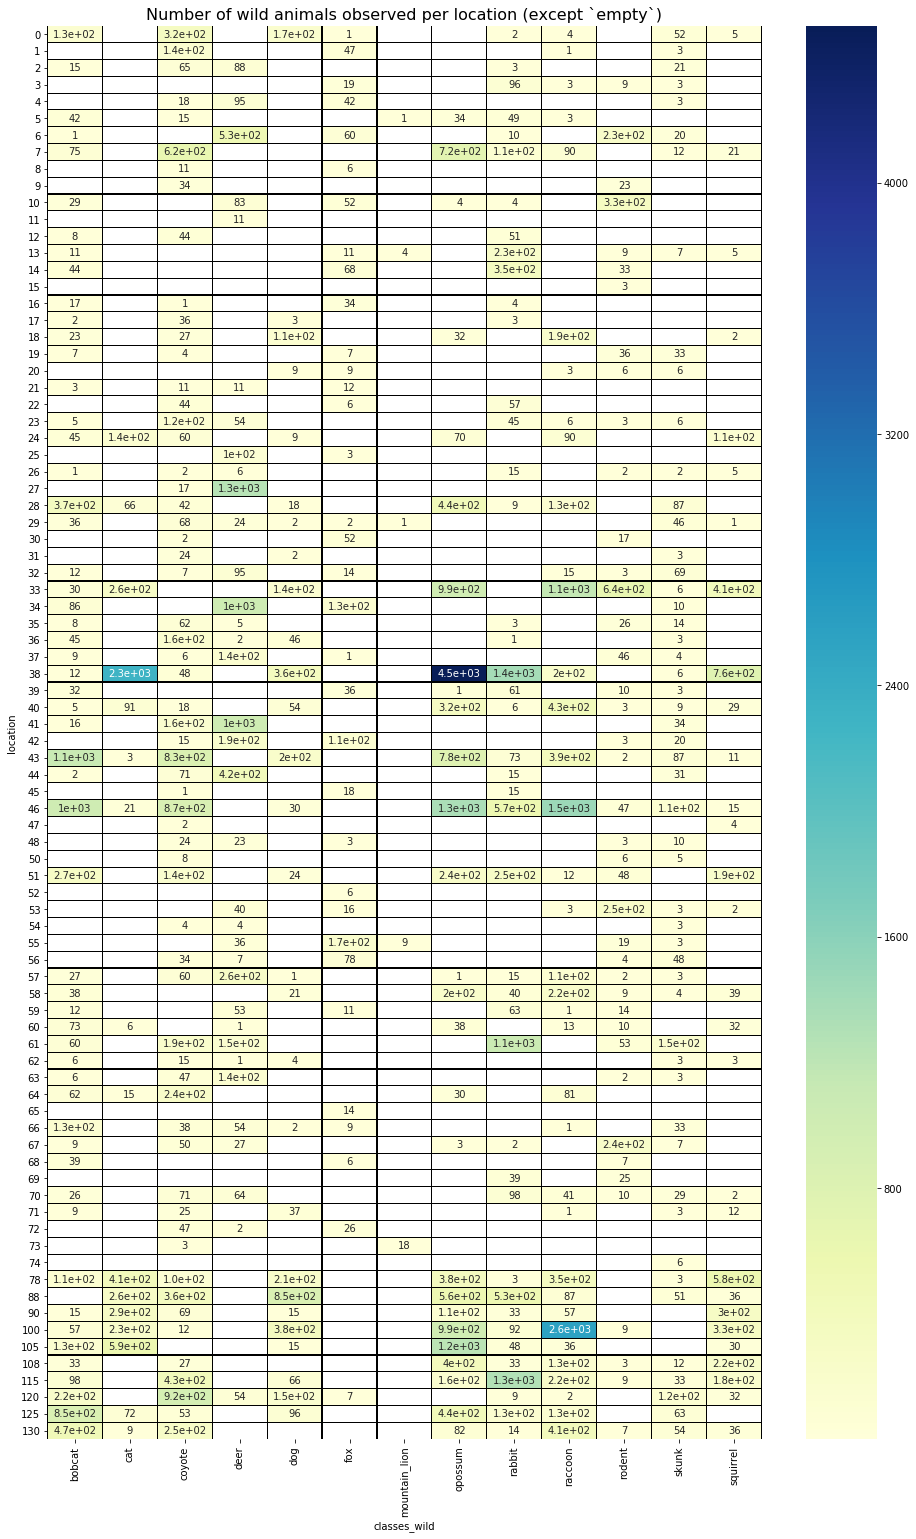

32913

In [18]:
fig, ax = plt.subplots(1,1,figsize=(16,26))
tmp = train_df[train_df['classes_wild'] != 'empty']
t = pd.DataFrame(tmp.groupby(['classes_wild', 'location'])['seq_id'].count().reset_index())
m = t.pivot(index='location', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed per location (except `empty`)', size=16)
plt.show()
del t, tmp, m
gc.collect()

### Rights holder

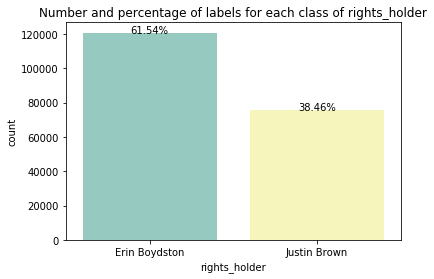

In [19]:
plot_classes('rights_holder', fs=3)

### Rights holder and wild animals class

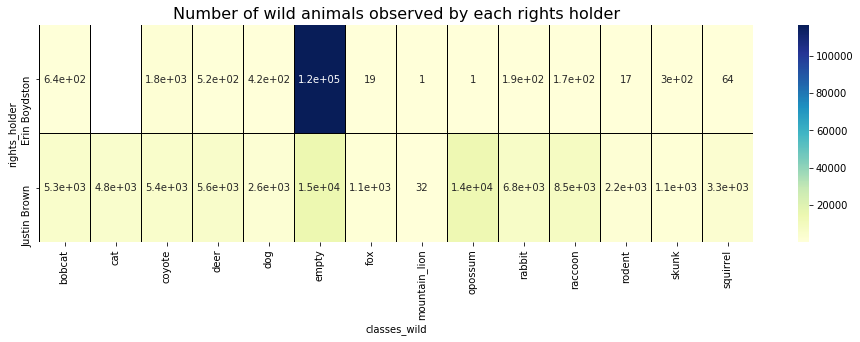

In [20]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
t = pd.DataFrame(train_df.groupby(['classes_wild', 'rights_holder'])['seq_id'].count().reset_index())
m = t.pivot(index='rights_holder', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed by each rights holder', size=16)
plt.show()

### Extract date and time information

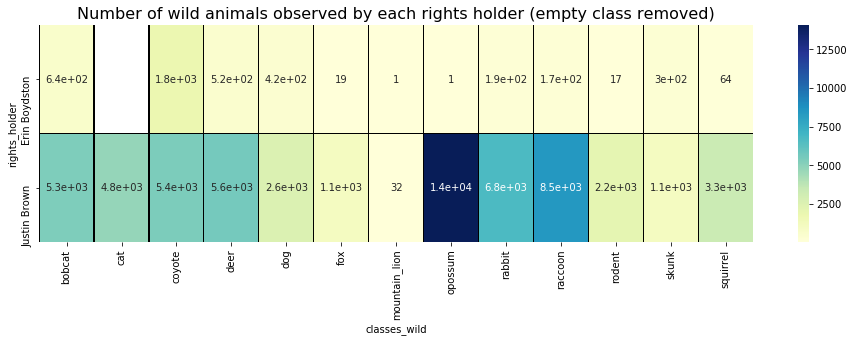

In [21]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
t = pd.DataFrame(train_df[~(train_df.classes_wild == 'empty')].groupby(['classes_wild', 'rights_holder'])['seq_id'].count().reset_index())
m = t.pivot(index='rights_holder', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed by each rights holder (empty class removed)', size=16)
plt.show()

In [22]:
try:
    train_df['date_time'] = pd.to_datetime(train_df['date_captured'], errors='coerce')
    train_df["year"] = train_df['date_time'].dt.year
    train_df["month"] = train_df['date_time'].dt.month
    train_df["day"] = train_df['date_time'].dt.day
    train_df["hour"] = train_df['date_time'].dt.hour
    train_df["minute"] = train_df['date_time'].dt.minute
except Exception as ex:
    print("Exception:".format(ex)) 

In [23]:
train_df.head()

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height,classes_wild,date_time,year,month,day,hour,minute
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747,opossum,2011-05-13 23:43:18,2011.0,5.0,13.0,23.0,43.0
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747,opossum,2012-03-17 03:48:44,2012.0,3.0,17.0,3.0,48.0
2,0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747,empty,2014-05-11 11:56:46,2014.0,5.0,11.0,11.0,56.0
3,0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747,empty,2013-10-06 02:00:00,2013.0,10.0,6.0,2.0,0.0
4,0,2011-07-12 13:11:16,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,3,599fbd89-23d2-11e8-a6a3-ec086b02610b,46,Justin Brown,6f1728a1-5567-11e8-9be7-dca9047ef277,3,1024,747,empty,2011-07-12 13:11:16,2011.0,7.0,12.0,13.0,11.0


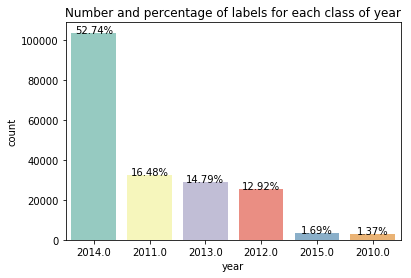

In [24]:
plot_classes('year', fs=3)

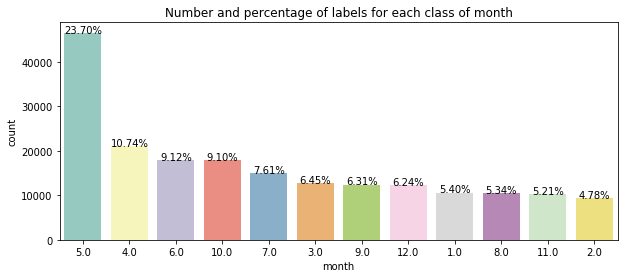

In [25]:
plot_classes('month', fs=5)

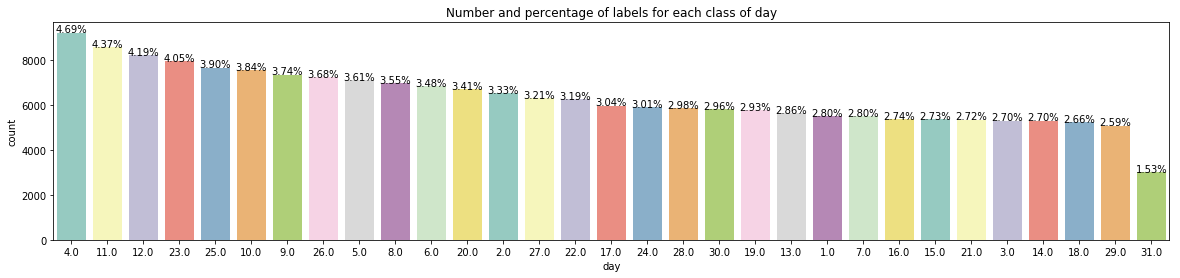

In [26]:
plot_classes('day', fs=10)

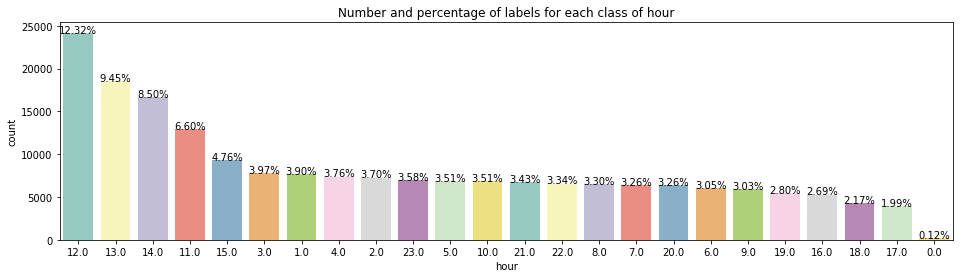

In [27]:
plot_classes('hour', fs=8)

### Classes and hours

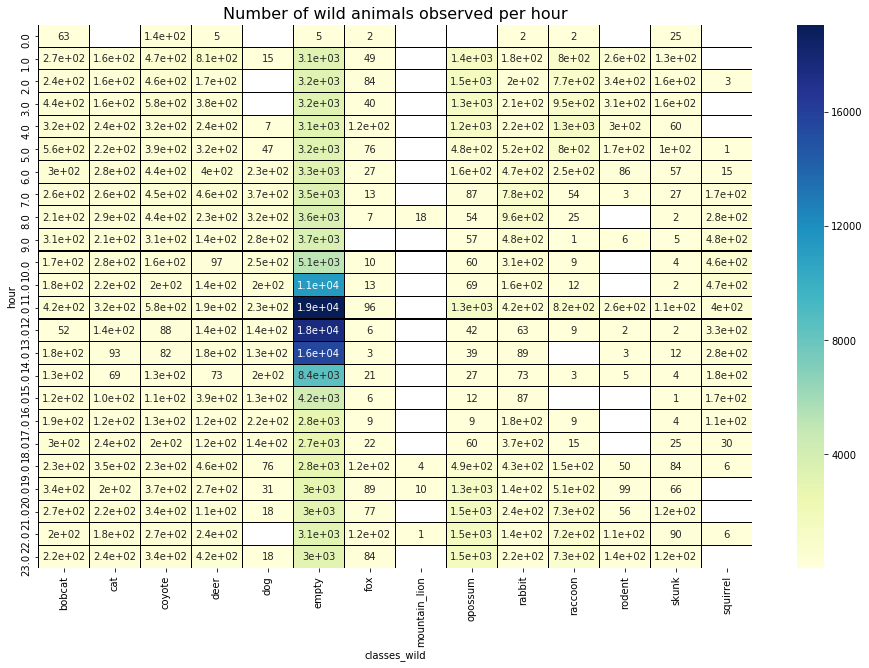

In [28]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
t = pd.DataFrame(train_df.groupby(['classes_wild', 'hour'])['seq_id'].count().reset_index())
m = t.pivot(index='hour', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed per hour', size=16)
plt.show()

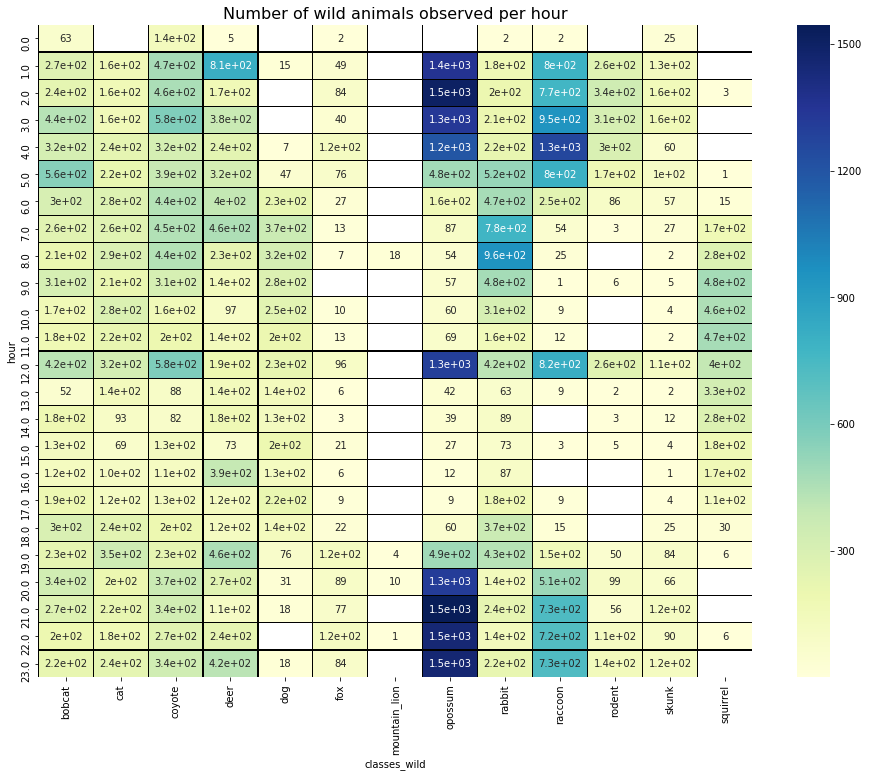

In [29]:
tmp = train_df[train_df['classes_wild'] != 'empty']
fig, ax = plt.subplots(1,1,figsize=(16,12))
t = pd.DataFrame(tmp.groupby(['classes_wild', 'hour'])['seq_id'].count().reset_index())
m = t.pivot(index='hour', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed per hour', size=16)
plt.show()

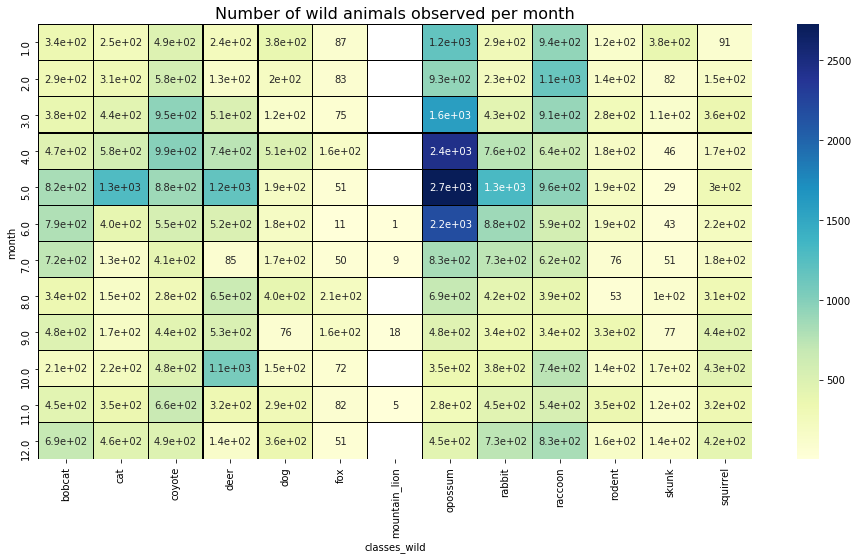

In [30]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
t = pd.DataFrame(tmp.groupby(['classes_wild', 'month'])['seq_id'].count().reset_index())
m = t.pivot(index='month', columns='classes_wild', values='seq_id')
s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=True, cmap="YlGnBu")
s.set_title('Number of wild animals observed per month', size=16)
plt.show()

### Classes per hour and month

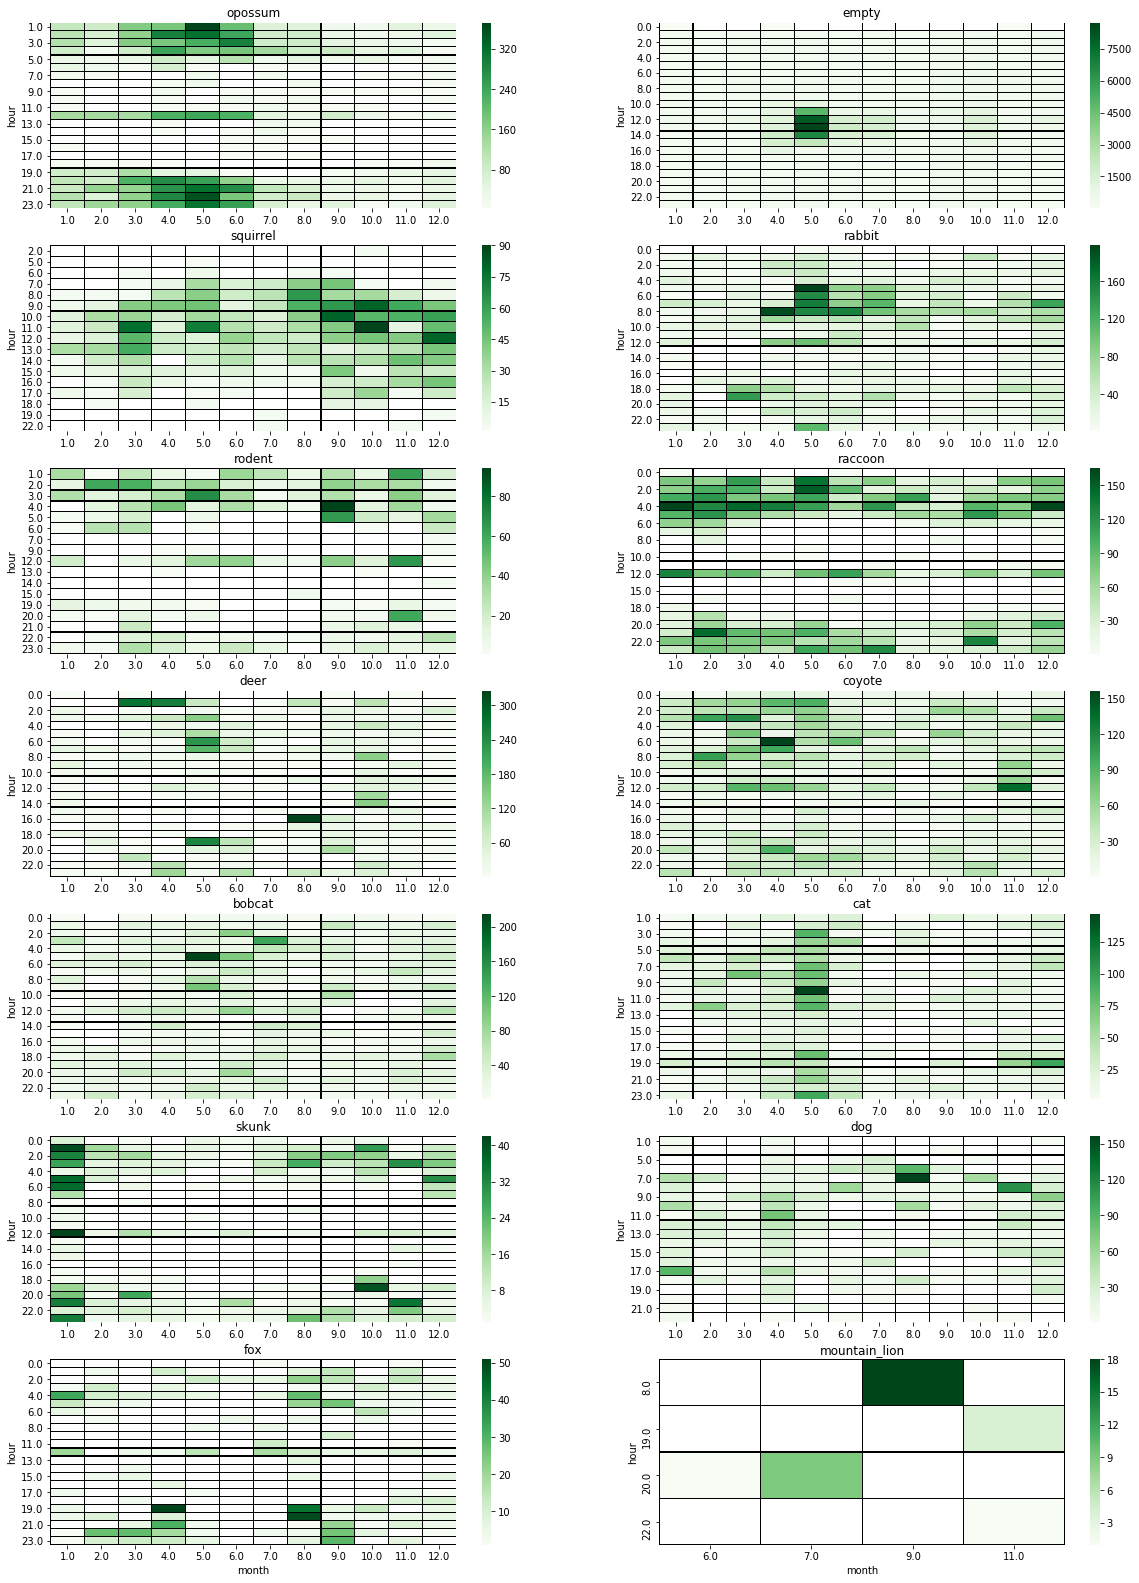

In [31]:
classes = train_df.classes_wild.unique()
fig, ax = plt.subplots(7,2,figsize=(20,28))
i = 0
for class_wild in classes:
    i = i + 1
    plt.subplot(7,2,i)
    tmp = train_df[train_df['classes_wild'] == class_wild]
    t = pd.DataFrame(tmp.groupby(['month', 'hour'])['seq_id'].count().reset_index())
    m = t.pivot(index='hour', columns='month', values='seq_id')
    s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=False, cmap="Greens")
    if(i<13):
        s.set_xlabel('')    
    s.set_title(class_wild, size=12)

plt.show()

### Classes per rights holder and month

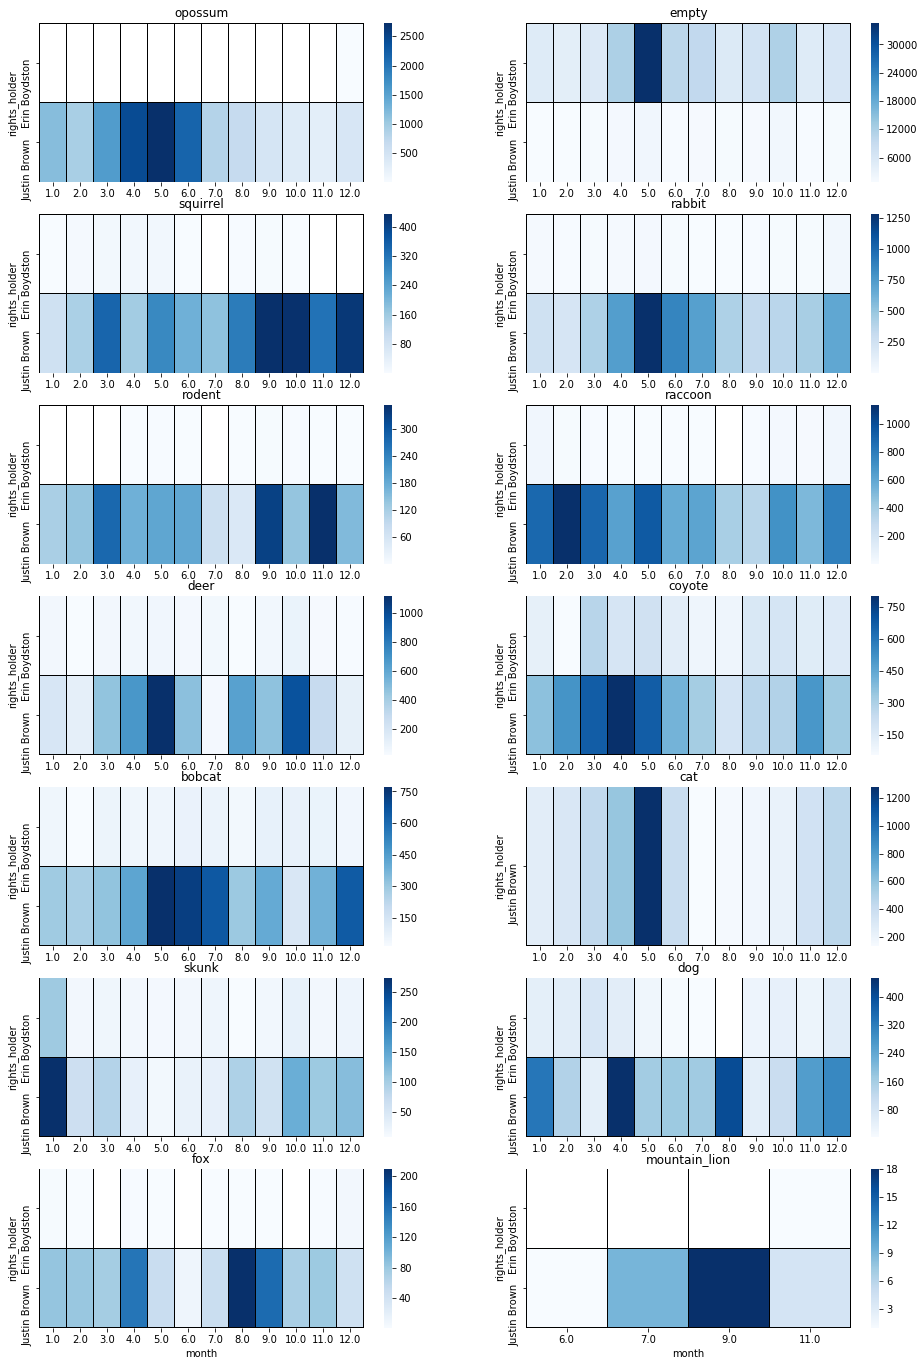

In [32]:
classes = train_df.classes_wild.unique()
fig, ax = plt.subplots(7,2,figsize=(16,24))
i = 0
for class_wild in classes:
    i = i + 1
    plt.subplot(7,2,i)
    tmp = train_df[train_df['classes_wild'] == class_wild]
    t = pd.DataFrame(tmp.groupby(['rights_holder', 'month'])['seq_id'].count().reset_index())
    m = t.pivot(index='rights_holder', columns='month', values='seq_id')
    s = sns.heatmap(m, linewidths=.1, linecolor='black', annot=False, cmap="Blues")
    if(i<13):
        s.set_xlabel('')    
    s.set_title(class_wild, size=12)

plt.show()

### Train images samples

In [33]:
def draw_category_images(var,cols=5):
    categories = (train_df.groupby([var])[var].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=cols, figsize=(3*cols,3*len(categories)))
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = train_df[train_df[var]==cat].sample(cols)
        for j in range(0,cols):
            file=IMAGE_PATH + sample.iloc[j]['file_name']
            im = Image.open(file)
            ax[i, j].imshow(im, resample=True)
            ax[i, j].set_title(cat, fontsize=9)  
    plt.tight_layout()
    plt.show()

In [ ]:
IMAGE_PATH = ('iwildcam_2019_fgvc6/train_images/')
draw_category_images('classes_wild')

### Test images samples

In [ ]:
IMAGE_PATH = ('test_images/')
f, ax = plt.subplots(nrows=5,ncols=5, figsize=(15,15))

for i in range(5):
    sample = test_df.sample(5)
    for j in range(5):
        file=IMAGE_PATH + sample.iloc[j]['file_name']
        im = Image.open(file)
        ax[i, j].imshow(im, resample=True)
        ax[i, j].set_title('Not labeled', fontsize=9)  
plt.tight_layout()
plt.show()

# Model

## Data pre-processing for model

### Image Train

In [ ]:
SOURCE_IMAGES_TRAIN = os.path.join("train_images/")

images_train = glob(os.path.join(SOURCE_IMAGES_TRAIN, "*.jpg"))

labels_train = pd.read_csv('train/train.csv')

### Images test

In [ ]:
SOURCE_IMAGES_TEST = os.path.join("test_images/")

images_test = glob(os.path.join(SOURCE_IMAGES_TEST, "*.jpg"))

labels_test = pd.read_csv('test/test.csv')

In [ ]:
# Affiche les 5 premières images de train du tableau 
images_train[0:5]

In [ ]:
# Affiche les 5 premières images de test du tableau 
images_test[0:5]

### Show three random images

In [ ]:
r = random.sample(images_train, 3)
r

# Matplotlib black magic
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(cv2.imread(r[0]))

plt.subplot(132)
plt.imshow(cv2.imread(r[1]))

plt.subplot(133)
plt.imshow(cv2.imread(r[2]));   

In [ ]:
labels_train

In [ ]:
# Example of bad x-ray and good reason to use data augmentation
e = cv2.imread(os.path.join(SOURCE_IMAGES_TRAIN,'590ebc52-23d2-11e8-a6a3-ec086b02610b.jpg'))

plt.imshow(e)
 
labels_train[labels_train["file_name"] == '590ebc52-23d2-11e8-a6a3-ec086b02610b.jpg']

In [ ]:
590ebc52-23d2-11e8-a6a3-ec086b02610b.jpg

### Turn images into arrays and make a list of classes

In [ ]:
def proc_images(images,WIDTH,HEIGHT,labels,index_name):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    
    disease="Infiltration"

    x = [] # images as arrays
    y = [] # labels Infiltration or Not_infiltration
  

    for img in images:
        base = os.path.basename(img)
        finding = labels["Finding Labels"][labels[index_name] == base].values[0]

        # Read and resize image
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))

        # Labels
        if disease in finding:
            #finding = str(disease)
            finding = 1
            y.append(finding)

        else:
            #finding = "Not_" + str(disease)
            finding = 0
            y.append(finding)

    return x_train,y_train

In [ ]:
WIDTH = 128
HEIGHT = 128
index_name = "file_name"

In [ ]:
x,y = proc_images(WIDTH,HEIGHT,labels_train,index_name)

## Scale the images

In [ ]:
£x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.